In [49]:
from imutils.perspective import four_point_transform
import cv2

In [50]:
height = 800
width = 600
green = (0, 255, 0)

image = cv2.imread("C:/Users/Administrator/Desktop/EasyFact/Model/JPG/Yes/9260852730.jpg")
image = cv2.resize(image, (width, height))
orig_image = image.copy()

In [51]:
##### Image processing ##########
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert the image to gray scale
blur = cv2.GaussianBlur(gray, (5, 5), 0) # Add Gaussian blur
edged = cv2.Canny(blur, 75, 200) # Apply the Canny algorithm to find the edges


In [52]:

# Show the image and the edges
cv2.imshow('Original image:', image)
cv2.imshow('Edged:', edged)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [53]:
############### Use the Edges to Find all the Contours #########
contours, _ = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

In [54]:
# Show the image and all the contours
cv2.imshow("Image", image)
cv2.drawContours(image, contours, -1, green, 3)
cv2.imshow("All contours", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [18]:
############# Select Only the Edges of the Document ########

In [55]:
# go through each contour
for contour in contours:
    # we approximate the contour
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.05 * peri, True)
    # if we found a contour with 4 points we break the for loop
    # (we can assume that we have found our document)
    if len(approx) == 4:
        doc_cnts = approx
        break

In [56]:
# We draw the contours on the original image not the modified one
cv2.drawContours(orig_image, [doc_cnts], -1, green, 3)
cv2.imshow("Contours of the document", orig_image)
# apply warp perspective to get the top-down view
warped = four_point_transform(orig_image, doc_cnts.reshape(4, 2))
# convert the warped image to grayscale
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
cv2.imshow("Scanned", cv2.resize(warped, (600, 800)))
cv2.waitKey(0)
# Save the processed image
cv2.imwrite('output.jpg', warped)

cv2.destroyAllWindows()

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
import re
from pytesseract import Output
from matplotlib import image as mpimg

from skimage.filters import threshold_local

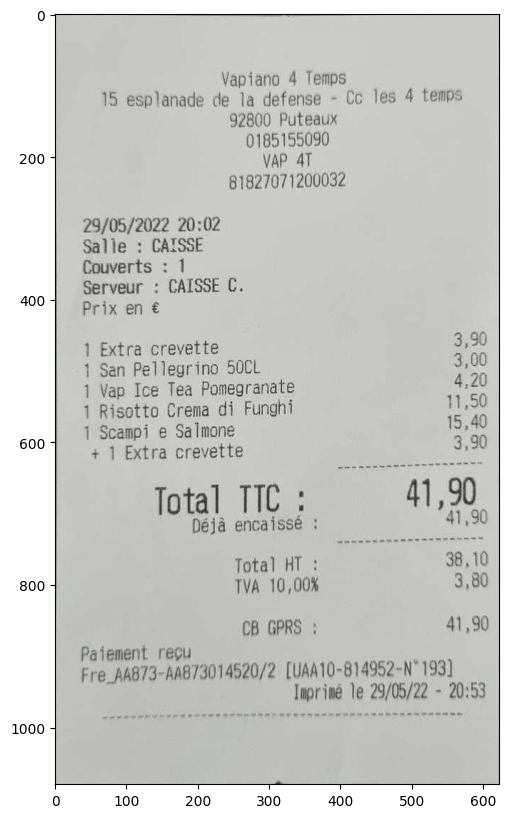

In [2]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

file_name = 'C:/Users/Administrator/Desktop/EasyFact/Model/JPG/Yes/9762039676.jpg'
image = mpimg.imread(file_name) 
plot_gray(image)

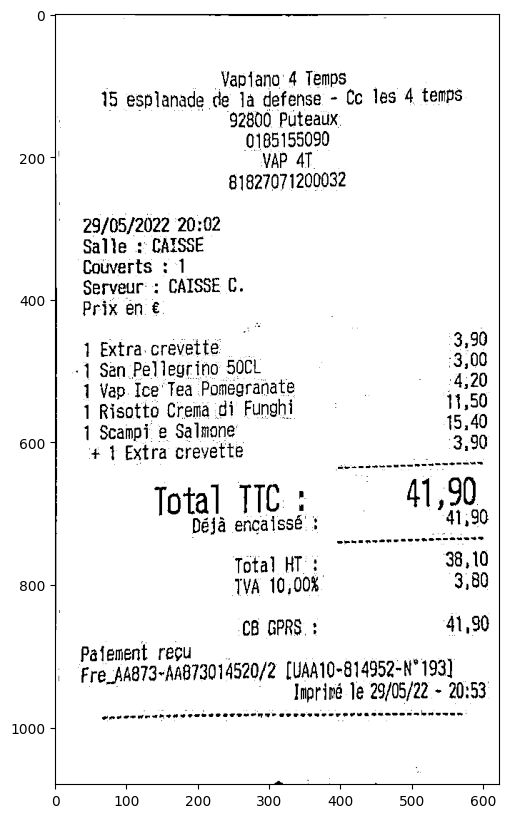

In [3]:
from skimage.filters import threshold_local
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

image = bw_scanner(image)
plot_gray(image)


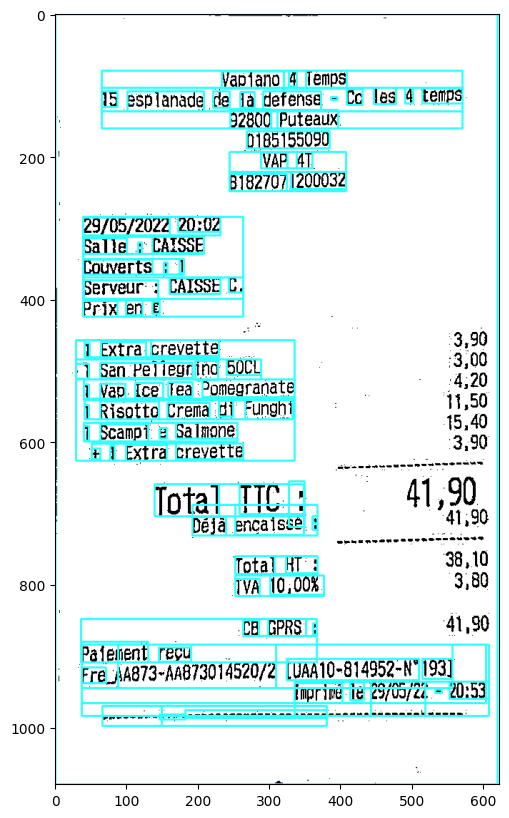

In [6]:
##################  Step 1: Text box detection ######################
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (255, 255, 50), 2)
    
plot_rgb(boxes)

[(252, 760, 307, 785)]
[252, 760, 307, 785]
Largest price box found: (547, 753, 606, 778)
Total: Total
Price: 38,10


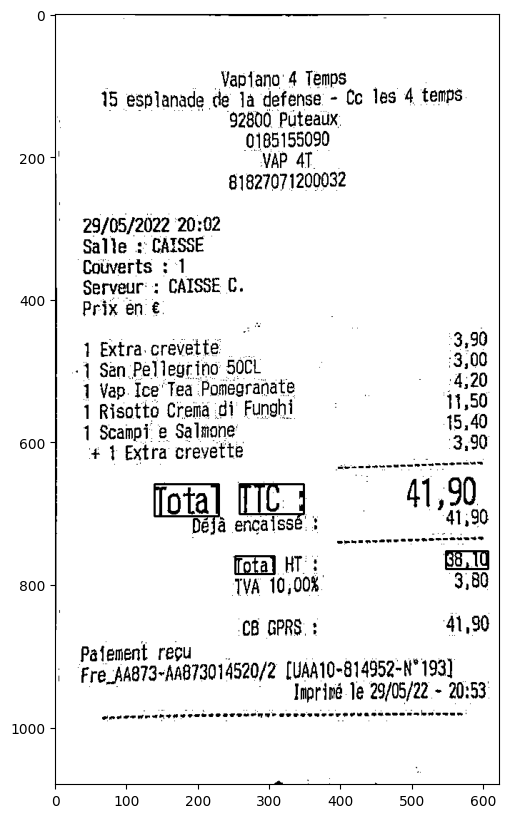

In [ ]:
# Récupérer les coordonnées des boîtes détectées par Tesseract
d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = []

# Parcourir toutes les boîtes et récupérer les coordonnées des boîtes contenant le mot "total"
for i in range(n_boxes):
    if d['text'][i].lower().startswith('total'):
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        boxes.append((x, y, x + w, y + h))
print(boxes)

# Déterminer le box conteneur qui contient le mot "total" et le prix correspondant
total_box = None
for box in boxes:
    if total_box is None:
        total_box = list(box)
    else:
        if box[1] == total_box[1]:
            total_box[0] = min(total_box[0], box[0])
            total_box[2] = max(total_box[2], box[2])
        elif box[1] > total_box[1]:
            break
print(total_box)


# Extraire le texte dans le box conteneur
#lang_file = r'C:\Program Files\Tesseract-OCR\tessdata\eng.traineddata'
#if total_box is not None:
#    x, y, w, h = total_box
#    total_text = pytesseract.image_to_string(image[y:y+h, x:x+w])
#    print("Total text: ", total_text)


# Trouver la boîte contenant le prix de "Total"
price_box = None
for i in range(n_boxes):
    if i != 0 and d['text'][i-2].lower().startswith('total'):
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        price_box = (x, y, x + w, y + h)
        break
# price_box = None
# max_price = -1

# for i in range(n_boxes):
#     text = d['text'][i].strip()
#     if text.isdigit():
#         price = int(text)
#         if price > max_price:
#             max_price = price
#             (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
#             price_box = (x, y, x + w, y + h)

if price_box is not None:
    # Do something with the price_box
    print(f"Largest price box found: {price_box}")
else:
    # No digit boxes found
    print("No digit boxes found")
# Get the text inside the total_box
total_text = ""
for i in range(n_boxes):
    if d['left'][i] >= total_box[0] and d['top'][i] >= total_box[1] \
        and d['left'][i] + d['width'][i] <= total_box[2] \
        and d['top'][i] + d['height'][i] <= total_box[3]:
        total_text += d['text'][i] + " "

# Get the text inside the price_box
price_text = ""
for i in range(n_boxes):
    if d['left'][i] >= price_box[0] and d['top'][i] >= price_box[1] \
        and d['left'][i] + d['width'][i] <= price_box[2] \
        and d['top'][i] + d['height'][i] <= price_box[3]:
        price_text += d['text'][i] + " "

# Print the total and price
print("Total:", total_text.strip())
print("Price:", price_text.strip())
# # Élargir le box conteneur pour inclure la boîte de prix de "Total"
# if price_box is not None:
#     total_box[2] = max(total_box[2], price_box[2])


# Encadrer le box conteneur et la boîte de prix dans l'image originale
cv2.rectangle(image, (total_box[0], total_box[1]), (total_box[2], total_box[3]), (0, 255, 0), 2)
if price_box is not None:
    cv2.rectangle(image, (price_box[0], price_box[1]), (price_box[2], price_box[3]), (0, 255, 0), 2)

# Récupérer le texte correspondant aux boîtes encadrées
total_text = pytesseract.image_to_string(image[total_box[1]:total_box[3], total_box[0]:total_box[2]], lang='eng')
if price_box is not None:
    price_text = pytesseract.image_to_string(image[price_box[1]:price_box[3], price_box[0]:price_box[2]], lang='eng')

# Afficher le texte correspondant aux boîtes encadrées
#print("Total: {}".format(total_text.strip()))
#if price_box is not None:
#    print("Prix: {}".format(price_text.strip()))

# Afficher l'image avec les boîtes encadrées
plot_rgb(image)


In [ ]:
##################  Step 2: Text recognition  ##################
extracted_text = pytesseract.image_to_string(image)
print(extracted_text)

Vapiano' 4 Temps
15 esplanade de 1a defense - Co les 4 temps
92800. Puteaux

0185155090
NAP 4T.
8182707120032
29/05/2022 ‘20:02
Salle + CAISSE
Coiiverts : 1
Serveur:: CAISSE C.
Prix en €
1 Extra. crevette 3,90
+1 San:Pellegr ino SOCL 3,00
1 Vap. Ice’ Tea Pomegranate :4,20
1 Risotto Creiia di’ Funghi 14,50
1 Scampi. e Salmone’ ae

+ 1 Extra crevette

ofa) OE, at

Total HT: 38,10
TVA 10,008: 3,80
CB GPRS. + 41,90

Patement recu
Fre MAB73-AMB73014520/2 (UAA10-814952-N" 193]
Inpriné le 29/05/22 - 20:53°

eneeenes! Rane entecarencnns aeereaecrnveastewenabneran




In [ ]:
###################### Step 3: Extracting grand total #####################
def find_amounts(text):
    amounts = re.findall(r'\d+[,.]\d{2}\b', text)
    floats = [float(amount.replace(',', '.')) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique
amounts = find_amounts(extracted_text)
max(amounts)

41.9